In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
from scipy import stats

In [2]:
from filters import kalman, kalman_enkf, kalman_ukf, sigma_points
from models import noise
from plots import plot_common, plot_kf_plus, plot_nonlinear, plot_sigmas

## Gaussian Distribution


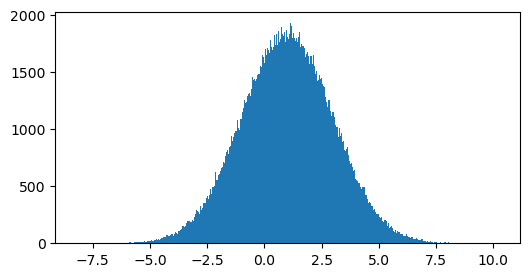

In [3]:
random.seed(123)

data = random.normal(loc=0.0, scale=1.0, size=500000)

_, ax = plt.subplots(figsize=(6, 3))

ax.hist(2 * data + 1, 1000);  # noqa: E703

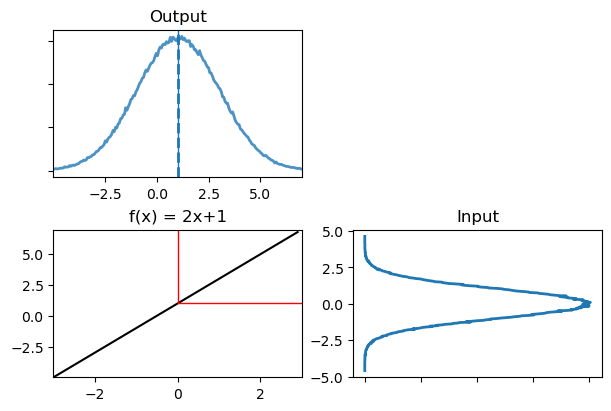

In [4]:
def g1(x):
    return 2 * x + 1


plot_nonlinear.plot_transferred_gaussian(data, g1, func_name="2x+1", figsize=(6, 4))

# plt.savefig('../images/gaussian-linear.png')

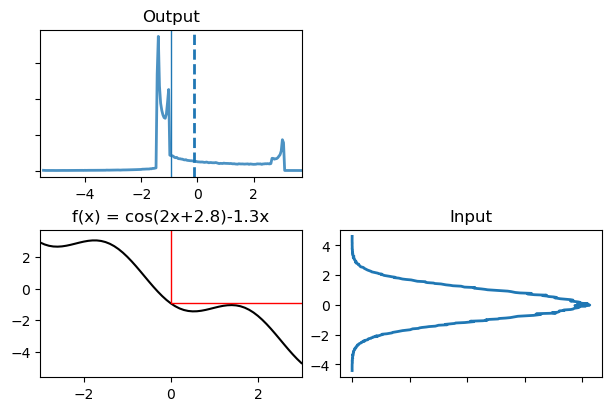

In [5]:
gaussian = (0.0, 1.0)
data = random.normal(loc=gaussian[0], scale=gaussian[1], size=500000)


def f(x):
    return (np.cos(2 * x + 2.8)) - 1.3 * x


plot_nonlinear.plot_transferred_gaussian(
    data, f, func_name="cos(2x+2.8)-1.3x", figsize=(6, 4)
)

# plt.savefig('../images/gaussian-nonlinear.png')

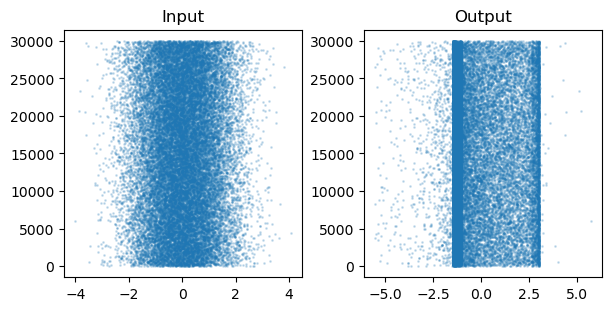

In [6]:
N = 30000

plot_nonlinear.plot_distributed_scatters(data, f, N)

# plt.savefig('../images/gaussian-nonlinear-scatter.png')

### Sigma Points


Difference in mean x=0.163, y=43.195


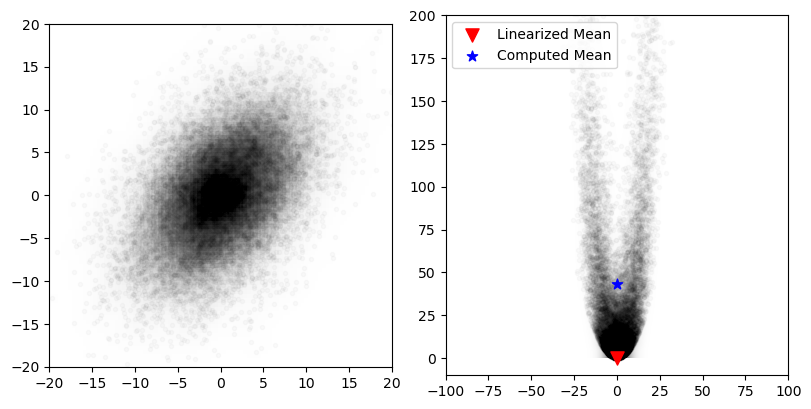

In [7]:
def f_nonlinear_xy(x, y):
    return np.array([x + y, 0.1 * x**2 + y * y])


mean = (0.0, 0.0)
p = np.array([[32.0, 15.0], [15.0, 40.0]])
# Compute linearized mean
mean_fx = f_nonlinear_xy(*mean)
# generate random points
xs, ys = random.multivariate_normal(mean=mean, cov=p, size=10000).T

_, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

plot_nonlinear.plot_monte_carlo_mean(
    axes, xs, ys, f_nonlinear_xy, mean_fx, "Linearized Mean", figsize=(6, 3)
)

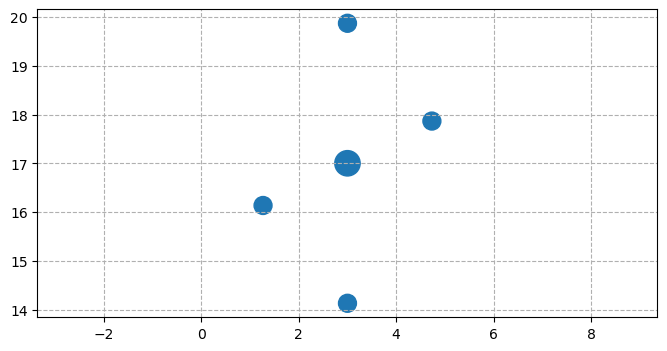

In [8]:
sigmas = sigma_points.JulierSigmas(n=2, kappa=1)

_, ax = plt.subplots(figsize=(8, 4))
plot_sigmas.plot_sigmas(ax, sigmas, x=[3, 17], cov=[[1, 0.5], [0.5, 3]])

# plt.savefig('../images/sigmas-julier.png')

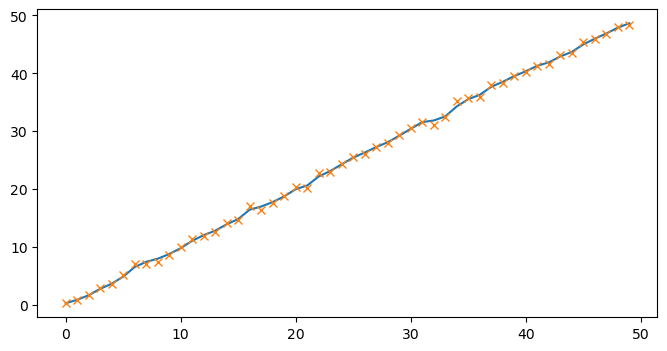

In [9]:
def fx(x, dt):
    xout = np.empty_like(x)
    xout[0] = x[1] * dt + x[0]
    xout[1] = x[1]
    return xout


def hx(x):
    return x[:1]


ukf = kalman_ukf.UnscentedKalmanFilter(
    dim_x=2,
    dim_z=1,
    dt=1.0,
    hx=hx,
    fx=fx,
    points=sigmas,
)
ukf.P *= 10
ukf.R *= 0.5
ukf.Q = noise.white_noise_discrete(2, dt=1.0, var=0.03)

zs, xs = [], []
for i in range(50):
    z = i + random.randn() * 0.5
    ukf.predict()
    ukf.update(z)
    xs.append(ukf.x[0])
    zs.append(z)

_, ax = plt.subplots(figsize=(8, 4))

ax.plot(xs)
ax.plot(zs, marker="x", ls="")

### Choosing Sigma Points


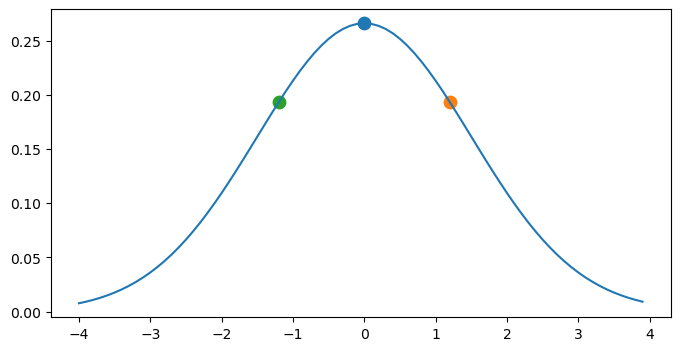

In [10]:
def show_3_sigma_points(ax):
    xs = np.arange(-4, 4, 0.1)
    var = 1.5
    ys = [stats.norm(0, var).pdf(x) for x in xs]
    samples = [0, 1.2, -1.2]
    for x in samples:
        ax.scatter([x], [stats.norm(0, var).pdf(x)], s=80)

    ax.plot(xs, ys)


_, ax = plt.subplots(figsize=(8, 4))

show_3_sigma_points(ax)
# plt.savefig('../images/sigmas-3.png')

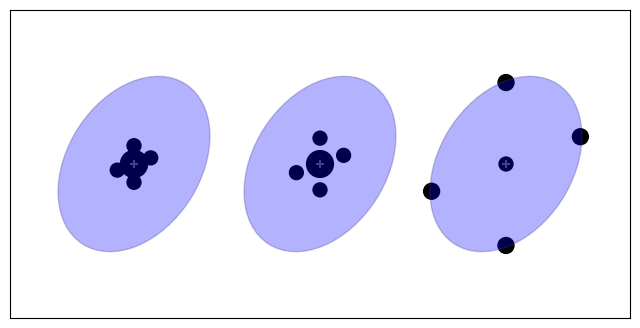

In [11]:
_, ax = plt.subplots(figsize=(8, 4))

plot_sigmas.plot_sigmas_selection(ax)

# plt.savefig('../images/sigmas-selection.png')

### Comparison


Difference in mean x=-0.097, y=0.549


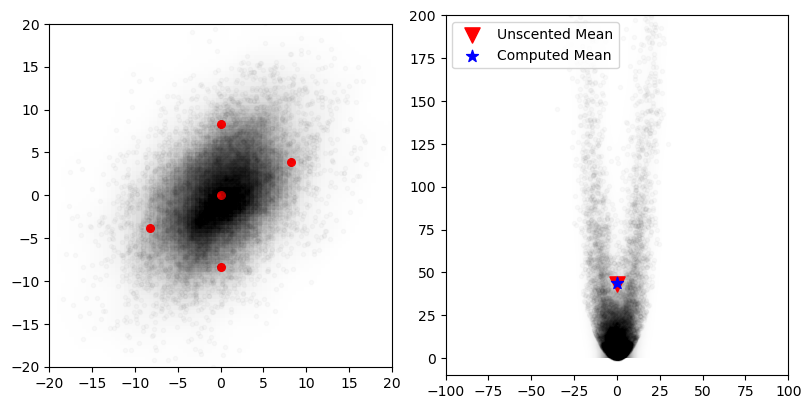

In [12]:
mean = (0.0, 0.0)
p = np.array([[32.0, 15], [15.0, 40.0]])

# create sigma points and weights
points = sigma_points.JulierSigmas(n=2, kappa=0.1)
sigmas = points.sigma_points(mean, p)

### pass through nonlinear function
sigmas_f = np.empty((5, 2))
for i in range(5):
    sigmas_f[i] = f_nonlinear_xy(sigmas[i, 0], sigmas[i, 1])

### use unscented transform to get new mean and covariance
ukf_mean, ukf_cov = kalman_ukf.unscented_transform(sigmas_f, points.Wm, points.Wc)

# generate random points
np.random.seed(100)
xs, ys = random.multivariate_normal(mean=mean, cov=p, size=5000).T

_, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

axes[0].scatter(sigmas[:, 0], sigmas[:, 1], c="r", s=30)
plot_nonlinear.plot_monte_carlo_mean(
    axes, xs, ys, f_nonlinear_xy, ukf_mean, "Unscented Mean"
)

Difference in mean x=-0.097, y=0.549


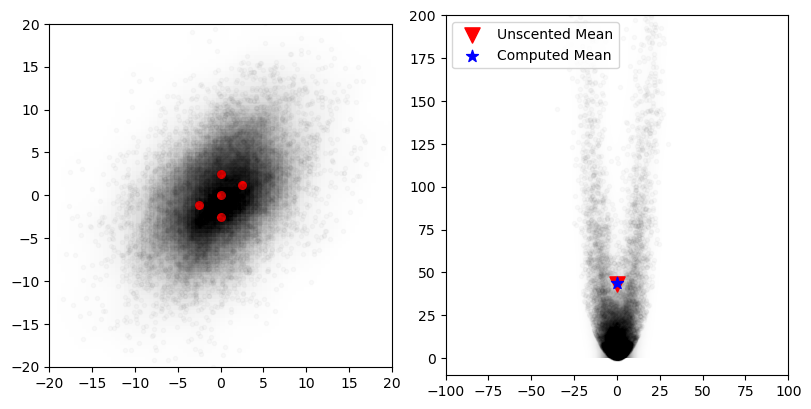

In [13]:
# initial mean and covariance
mean = (0.0, 0.0)
p = np.array([[32.0, 15], [15.0, 40.0]])

# create sigma points and weights
points = sigma_points.MerweScaledSigmas(n=2, kappa=0.1, alpha=0.3, beta=2.0)
sigmas = points.sigma_points(mean, p)

### pass through nonlinear function
sigmas_f = np.empty((5, 2))
for i in range(5):
    sigmas_f[i] = f_nonlinear_xy(sigmas[i, 0], sigmas[i, 1])

### use unscented transform to get new mean and covariance
ukf_mean, ukf_cov = kalman_ukf.unscented_transform(sigmas_f, points.Wm, points.Wc)

# generate random points
np.random.seed(100)
xs, ys = random.multivariate_normal(mean=mean, cov=p, size=5000).T

_, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

axes[0].scatter(sigmas[:, 0], sigmas[:, 1], c="r", s=30)
plot_nonlinear.plot_monte_carlo_mean(
    axes, xs, ys, f_nonlinear_xy, ukf_mean, "Unscented Mean"
)

## Unscented Kalman Filter


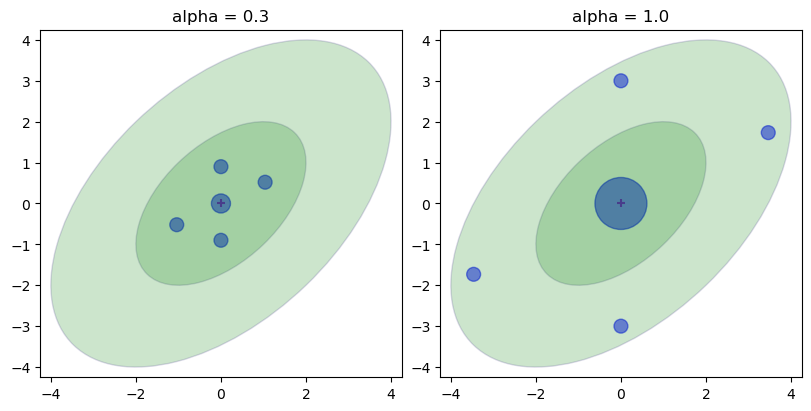

In [14]:
_, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

plot_sigmas.plot_sigmas_compar_param(axes, obj="alpha")

# plt.savefig("../images/sigmas-merwe.png")

## Extended Kalman Filter


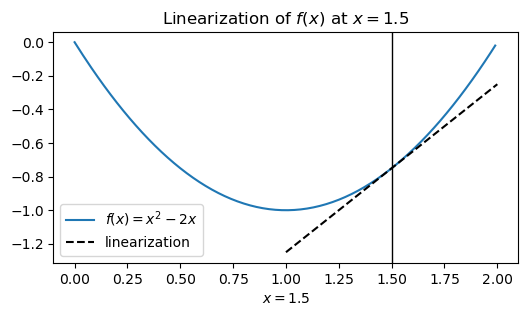

In [15]:
_, ax = plt.subplots(figsize=(6, 3))

plot_kf_plus.show_linearization(ax, tan_x=1.5)

# plt.savefig("../images/efk-linearization.png")

## Comparison


actual mean=1.30, std=1.12
EKF    mean=1.00, std=0.95
actual mean=1.30, std=1.13
UKF    mean=1.30, std=1.08


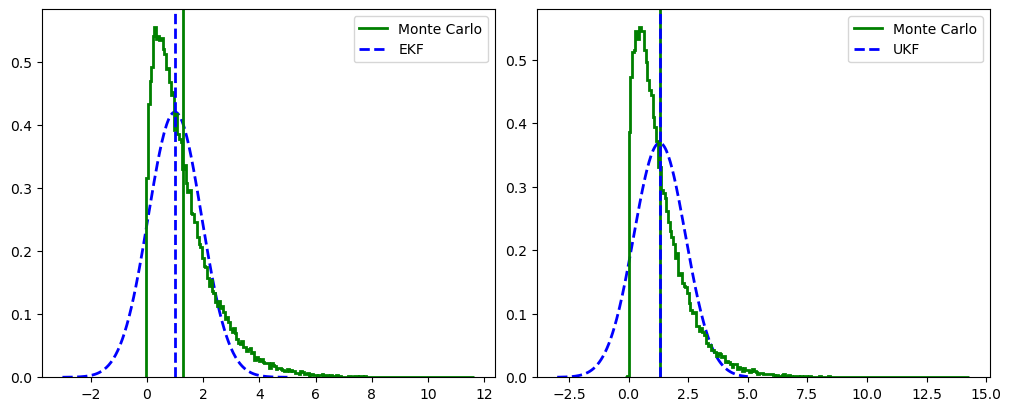

In [16]:
_, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

plot_kf_plus.plot_ekf_vs_mc(axes[0])
plot_kf_plus.plot_ukf_vs_mc(axes[1])

# plt.savefig("../images/efk-ufk.png")

## Ensemble Kalman Filter


<>:56: SyntaxWarning: invalid escape sequence '\s'
<>:56: SyntaxWarning: invalid escape sequence '\s'
/var/folders/py/n14256yd5r5ddms88x9bvsv40000gn/T/ipykernel_76976/1304617523.py:56: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(results - ps, c="k", linestyle=":", lw=1, label="1$\sigma$")


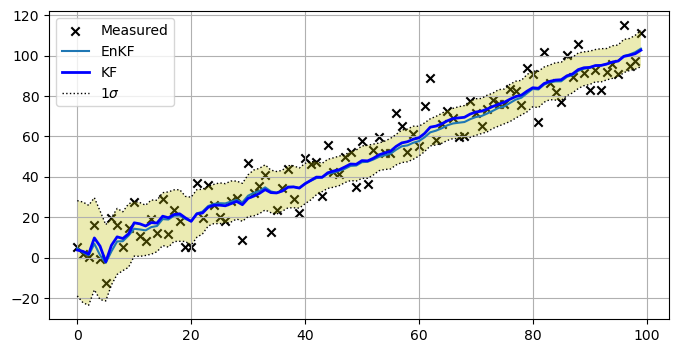

In [17]:
np.random.seed(1234)


def hx(x):
    return np.array([x[0]])


def fx(x, dt):
    return np.dot(F, x)


F = np.array([[1.0, 1.0], [0.0, 1.0]])
x = np.array([0.0, 1.0])
P = np.eye(2) * 100.0
enkf = kalman_enkf.EnsembleKalmanFilter(x=x, P=P, dim_z=1, dt=1.0, N=20, hx=hx, fx=fx)
std_noise = 10.0
enkf.R *= std_noise**2
enkf.Q = noise.white_noise_discrete(2, 1.0, 0.001)
kf = kalman.KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([x]).T
kf.F = F.copy()
kf.P = P.copy()
kf.R = enkf.R.copy()
kf.Q = enkf.Q.copy()
kf.H = np.array([[1.0, 0.0]])

measurements = []
results = []
ps = []
kf_results = []

zs = []
for t in range(100):
    # create measurement = t + white noise
    z = t + random.randn() * std_noise
    zs.append(z)
    enkf.predict()
    enkf.update(np.asarray([z]))
    kf.predict()
    kf.update(np.asarray([[z]]))

    # save data
    results.append(enkf.x[0])
    kf_results.append(kf.x[0, 0])
    measurements.append(z)
    ps.append(3 * (enkf.P[0, 0] ** 0.5))

results = np.asarray(results)
ps = np.asarray(ps)

_, ax = plt.subplots(figsize=(8, 4))

plot_common.plot_zs(ax, measurements)
ax.plot(results, label="EnKF")
ax.plot(kf_results, label="KF", c="b", lw=2)
ax.plot(results - ps, c="k", linestyle=":", lw=1, label="1$\sigma$")
ax.plot(results + ps, c="k", linestyle=":", lw=1)
ax.fill_between(range(100), results - ps, results + ps, facecolor="y", alpha=0.3)
ax.legend()